<a href="https://colab.research.google.com/github/lukechn99/hthesis/blob/main/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630171 sha256=bfcaf86231bf6e283312d8920e9f1d01c0265a604222d161b998c80e45a5689d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
import numpy as np
from surprise.prediction_algorithms.predictions import Prediction
import pandas as pd
import time
import math
# import psutil # Can be found at https://pypi.org/project/psutil/

# Recommender Algorithms
Implementation of ILFM

In [31]:
class ILFM():
    def __init__(self, k=50, inv=0):# we will change k in the next task
        # k: number of hidden features
        self.predict_ratings = None
        self.k=k
        self.inv = inv
        self.bias = 0
        self.user_bias = None
        self.item_bias = None

    def fit(self, trainset, learning_rate=0.001, n_iter=10, gamma = 0.015):
        raw_ratings = pd.DataFrame([x for x in trainset.all_ratings()],
                                   columns=["userId", "movieId", "ratings"])
        print(raw_ratings.head())
        self.ratings = raw_ratings.pivot(index='userId', columns='movieId', values='ratings')
        self.ratings.index = self.ratings.index.map(str) # get the list of userId (type str)
        self.ratings.columns = self.ratings.columns.map(str) # get the list of movieId (type str)
        self.predict_ratings = None

        ratings = self.ratings.values
        n_users = ratings.shape[0]
        n_movies = ratings.shape[1]
        print(self.ratings.head())
        # print(ratings.head())
        print(n_users, n_movies)

        # here we initialize a random user by feature matrix and a random feature by movie matrix.
        # you will need to optimize the entries of these 2 matrices in your funksvd algorithm
        user_feature = np.random.rand(n_users, self.k) 
        movie_feature = np.random.rand(self.k, n_movies)

        # self.user_bias = np.random.rand(n_users)
        # self.item_bias = np.random.rand(n_movies)

        # train ratings matrix
        for feature in range(self.k):
          print("training feature", feature)
          for _ in range(n_iter):
            for idx, r in raw_ratings.iterrows():
              # select the right row and column from user_feature and movie_feature matrices
              i = int(r[0])
              j = int(r[1])
              row = user_feature[i, :feature+1] # could optimize here to only calculate the current feature and store all previous calculations
              col = movie_feature[:feature+1, j]

              # find dot product (predicted_rating)
              predicted_rating = np.dot(row, col)# + self.bias + self.user_bias[i] + self.item_bias[j]

              # find the difference between rating and predicted_rating
              diff = r[2] - predicted_rating

              # self.bias += learning_rate * (diff - gamma * self.bias)
              # self.user_bias[i] += learning_rate * (diff - gamma * self.user_bias[i])
              # self.item_bias[j] += learning_rate * (diff - gamma * self.item_bias[j])
              
              # learn/fit the data for each k
              user_feature[i, feature] += learning_rate * (diff * movie_feature[feature, j] - gamma * user_feature[i, feature])
              movie_feature[feature, j] += learning_rate * (diff * user_feature[i, feature] - gamma * movie_feature[feature, j])
        
        # print(user_feature[0])
        # user_feature[:, self.inv] = abs(user_feature[:, self.inv]-1)
        # user_feature[:, self.inv] *= -1
        # print(user_feature[0])

        # add ratings over to self.predicted_ratings
        self.predict_ratings = pd.DataFrame(np.matmul(user_feature, movie_feature), index=self.ratings.index, columns=self.ratings.columns)
        # n_df = pd.concat([df] * n)
        # user_bias = pd.DataFrame(pd.np.tile(self.user_bias, (n_users, 1)))
        # item_bias = pd.DataFrame(pd.np.tile(self.item_bias, (1, n_movies)))
        self.predict_ratings = self.predict_ratings #+ self.bias + user_bias + item_bias

    def test(self, testset):
      predictions = []
      for userId, movieId, true_rating in testset:
        if userId in self.predict_ratings.index and movieId in self.predict_ratings.columns and not np.isnan(self.predict_ratings.loc[userId, movieId]):
          pred_rating = self.predict_ratings.loc[userId, movieId]
          predictions.append(Prediction(uid=userId, iid=movieId, r_ui=true_rating, est=pred_rating, details={'was_impossible': False}))
        else:
          predictions.append(Prediction(uid=userId, iid=movieId, r_ui=true_rating, est=10, details={'was_impossible': True}))
      return predictions

Baseline comparison algorithms

In [5]:
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.matrix_factorization import SVD

# Dataset and Shuffle

In [6]:
from surprise.model_selection import KFold
# from sklearn.model_selection import KFold
from surprise import Dataset, accuracy
from surprise.reader import Reader
import random
import copy

# r_cols = ['userId', 'movieId', 'rating', 'tstamp']
# udata = pd.read_csv('drive/MyDrive/Colab/ml-100k/u.data', sep='\t', names=r_cols)
# tmp = pd.DataFrame(udata, columns=["userId", "movieId", "rating", "tstamp"])
# rating_df = tmp.pivot(index='userId', columns='movieId', values='rating')

# def my_split(data, n_splits=5, random_state=2021):
#   kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
#   dataset = []
#   for i in range(5):
#     result = next(kf.split(rating_df), None)
#     train = rating_df.iloc[result[0]]
#     test = rating_df.iloc[result[1]]
#     test_unpivot = test.reset_index().melt(id_vars='userId', var_name='movieId', value_name='rating')

#     # remove nan values
#     test_list = [entry for entry in list(test_unpivot.to_records(index=False)) if not math.isnan(entry[2])]

#     # convert nans to 0
#     # test_list = [(entry[0], entry[1], 0) if math.isnan(entry[2]) else entry for entry in list(test_unpivot.to_records(index=False))]
#     dataset.append((train, test_list))
#   return dataset

#############################

# reader = Reader(line_format=u'user item rating', sep='\t', rating_scale=(1, 5), skip_lines=1)
# data = Dataset.load_from_file('drive/MyDrive/Colab/ml-100k/u.data', reader=reader)
# tmp = pd.DataFrame(data.raw_ratings, columns=["userId", "movieId", "rating", "tstamp"])
# rating_df = tmp.pivot(index='userId', columns='movieId', values='rating')

data = Dataset.load_builtin('ml-100k')
tmp = pd.DataFrame(data.raw_ratings, columns=["userId", "movieId", "rating", "tstamp"])
rating_df = tmp.pivot(index='userId', columns='movieId', values='rating')

def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

non_rated_movies = []
for userId in rating_df.index:
  tmp = rating_df.loc[userId].loc[rating_df.loc[userId].isna()].index
  for movieId in tmp:
    non_rated_movies.append((userId, movieId, 0))

n_splits=5
non_rated_testset = partition(non_rated_movies, n_splits)

def my_split(data, n_splits=n_splits, random_state=2021):
    kf = KFold(n_splits=n_splits, random_state=random_state)

    dataset = []
    i = 0
    tmp = copy.deepcopy(data)
    for trainset, testset_rated in kf.split(tmp):
      testset_withunrated = copy.deepcopy(testset_rated)
      testset_withunrated.extend(non_rated_testset[i][:len(testset_rated)])
      dataset.append((trainset, testset_rated, testset_withunrated))
      i += 1
    return dataset

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


# Determine Size of Latent Factor Dimension (K)

In [ ]:
import heapq
import matplotlib.pyplot as plt

def findBestK(data, min_k, max_k, folds=5):
    split = my_split(data)
    results = pd.DataFrame(0, index=["MAE", "RMSE"], columns=[i for i in range(min_k, max_k + 1)])

    for k in range(min_k, max_k + 1):
        for fold in split:
            # extract datasets
            trainset = fold[0]
            testset_rated = fold[1]
            testset_withunrated = fold[2]

            svd = SVD(n_factors=k)
            svd.fit(trainset)
            prediction = svd.test(testset_rated)

            # record the accuracy
            results.loc["MAE", k] += accuracy.mae(prediction)
            results.loc["RMSE", k] += accuracy.rmse(prediction)
    results = results / folds
    return results

# results = findBestK(data, 0, 100)

In [ ]:
# results.loc["RMSE"].plot.bar()
# plt.xlabel("Number of Latent Factors")
# plt.ylabel("RMSE")
# plt.ylim(0.93, 0.945)
# plt.locator_params(axis='x', nbins=10)

# print(results)

In [ ]:
# results.loc["MAE"].plot.bar()
# plt.xlabel("Number of Latent Factors")
# plt.ylabel("MAE")
# plt.locator_params(axis='x', nbins=10)

# plt.ylim(0.73, 0.75)
# print(results)

In [ ]:
# print(results.idxmin(axis=1))

In [ ]:
# https://dzone.com/articles/python-how-to-add-trend-line-to-line-chartgraph
# fig, ax = plt.subplots(2, 1, figsize=(9, 7), sharex=True, sharey=False)
# X = np.array([i for i in range(101)])

# mae = results.loc["MAE"].to_numpy()
# y = np.polyfit(X, mae, 2)
# q = np.poly1d(y)
# ax[0].plot(X,q(X),"r--")
# ax[0].plot(X, mae)
# ax[0].set_title('MAE', fontsize=14)

# rmse = results.loc["RMSE"].to_numpy()
# z = np.polyfit(X, rmse, 2)
# p = np.poly1d(z)
# ax[1].plot(X,p(X),"r--")
# ax[1].plot(X, rmse)
# ax[1].set_title('RMSE', fontsize=14)

# Evaluation of the ILFM
Evaluate on accuracy metrics, diversity metrics, novelty, unexpectedness, and relevance. 

Accuracy metrics using MAE and RMSE

In [7]:
from surprise.accuracy import mae, rmse

Diversity metrics using ILS

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')
# movie_tags = pd.read_csv('drive/MyDrive/Colab/ml-100k/movie_tag_rel.csv', index_col=0)
movie_tags = pd.DataFrame()

from heapq import heappush, nlargest

def intra_similarity_aux(items):
    """
    takes a list of items and calculates their intra list similarity with the movie tags from movie_tags
    returns a float
    """
    correlation_sum = 0
    number_of_pairs = 0
    for i in range(len(items)):
      for j in range(i + 1, len(items)):
        correlation_sum += movie_tags.loc[items[i]].corr(movie_tags.loc[items[j]])
        number_of_pairs += 1
    return correlation_sum / max(number_of_pairs, 1)

def intra_similarity(surprise_predictions, k_highest_scores=5):
    """ 
    Calculates the intra-similarity score from surprise predictions
  
    Parameters: 
    surprise_predictions (List of surprise.prediction_algorithms.predictions.Prediction): list of predictions, 
    see https://surprise.readthedocs.io/en/stable/predictions_module.html?highlight=prediction#surprise.prediction_algorithms.predictions.Prediction 
    k_highest_scores (positive integer): Only consider the highest k scores (items) in each user's recommendation list.
  
    Returns: 
    float in [-1, 1.]: The averaged ILS@5 over all users' recommendation lists
    """
    uidset = list(set([p.uid for p in surprise_predictions]))
    iidset = list(set([p.iid for p in surprise_predictions]))
    ratings = pd.DataFrame(index=uidset, columns=iidset)
    
    # we create a hashmap of each user to a top-5 maxheap of (rating, iid)
    users_top_5 = {}
    for user in uidset:
      users_top_5[user] = []

    for prediction in surprise_predictions:
      ratings.loc[prediction.uid, prediction.iid] = prediction.est
      heappush(users_top_5[prediction.uid], (prediction.est, prediction.iid))
    ratings.fillna(0, inplace=True) # now we've transformed the predictions into a userId x movieId pred_rating dataframe    
    # print(ratings.head())
    numerator = 0
    denominator = 0
    empty_user = 0
    for user in uidset:
      top_5 = nlargest(5, users_top_5[user])
      # discard the rating, only look at the movie ID
      top_5_and_valid = [r[1] for r in top_5 if r[1] in movie_tags.index.values]
      if len(top_5_and_valid) > 1:
        similarity_for_user = intra_similarity_aux(top_5_and_valid)
        numerator += similarity_for_user
        denominator += 1
        print("numerator", numerator, "denominator", denominator)
      else:
        empty_user += 1
    # print("there are {}/{} users with empty lists".format(empty_user, denominator))
    intra_similarity_score = numerator / (2 * max(denominator, 1))
    # print("IS: {}".format(intra_similarity_score))
    return intra_similarity_score

Novelty metrics using Vargas and Castells' measurement for novelty which looks at the distance away from a user's items that a new item is. 



In [9]:
def vargasNovelty(surprise_predictions, k=50):
    '''
    Similar to how we take nDCG@k, where k is some value like 5, vargasNovelty
    is to be taken by calculating novelty for each inverted prediction matrix 
    based on the top k values
    surprise_predictions is a list of lists. Each outer list represents a prediction
    matrix 
    '''
    total_nov = []
    uidset = list(set([p.uid for p in surprise_predictions]))
    iidset = list(set([p.iid for p in surprise_predictions]))
    ratings = pd.DataFrame(index=uidset, columns=iidset)
    for prediction in surprise_predictions:
      ratings.loc[prediction.uid, prediction.iid] = prediction.est
    ratings.fillna(0, inplace=True)
    # find top 5 from each "predictions"
    users_top = {}
    for user in uidset:
      users_top[user] = []

    for p in surprise_predictions:
      heappush(users_top[p.uid], (p.est, p.iid))
    # calculate novelty
    for user in uidset:
      top_k = nlargest(k, users_top[user])
      for i in range(len(top_k)):
        ith_item_score, ith_item = top_k[i]
        # this is a slightly modified novelty function that removes the constant and simplifies rel() and adjusted log() for zero indexing
        nov = (1/max(1, math.log(i+1,2))) * 2**(float(ith_item_score)-5) * (1-np.count_nonzero(ratings.loc[:, ith_item])/len(uidset))
      total_nov.append(nov)
    avg_nov = np.mean(total_nov)
    return avg_nov

def basicNovelty(surprise_predictions, k_highest_scores=5):
    # create the predicted ratings matrix and fill 0 for empty spaces
    uidset = list(set([p.uid for p in surprise_predictions]))
    iidset = list(set([p.iid for p in surprise_predictions]))
    ratings = pd.DataFrame(index=uidset, columns=iidset)
    for prediction in surprise_predictions:
      ratings.loc[prediction.uid, prediction.iid] = prediction.est
    ratings.fillna(0, inplace=True)

    # using the rating_df, defined as "rating_df = tmp.pivot(index='userId', columns='movieId', values='rating')", check for novelty

    # filter for top results by user
    users_top_5 = {}
    for user in uidset:
      users_top_5[user] = []

    for p in surprise_predictions:
      heappush(users_top_5[p.uid], (p.est, p.iid, p.r_ui))
    
    seen = 0
    unseen = 0

    # we find the ratio of seen to unseen 
    for user in users_top_5.keys():
      top_5 = nlargest(5, users_top_5[user])
      for item in top_5:
        # print(rating_df.loc[user, item[1]])
        if np.isnan(rating_df.loc[user, item[1]]):
          unseen += 1
        else:
          seen += 1
    return seen / max(unseen + seen, 1)



Unexpectedness metrics using Kaminskas and Bridge's research and metric

In [10]:
def unexpectedness_aux(user_id, top_5, ratings):
  '''
  roughly, we're following the equation -log( p(i,j)/p(i)p(j) ) / log(p(i,j))
  The p(i) is going to be calculated for each item in the user's item corpus
  calculated ahead of time in the pre-processing step

  user_id: userId
  top_5: List[Tuple(est, itemId)]
  ratings: pd.df
  '''
  total_pmi = []

  # pre-process the stats for items the user has rated
  user_rated_items = np.array(ratings.index.to_list())[ratings[user_id] > 0]

  # item-to-p(i) map
  p_i = {}

  # item-to-p(i) indices map. this is used to calculate p(i,j) later
  p_ii = {}

  print(user_rated_items)
  for item_id in user_rated_items:
    print("item_id", item_id)

    # probability of item i considering all items
    p_i[item_id] = np.count_nonzero(ratings.loc[:,item_id])/ratings.shape[1]
    p_ii[item_id] = np.nonzero(np.array(ratings.loc[:,item_id]))

  for item in top_5:
    item_id = item[1]   # int
    p_j = np.count_nonzero(ratings.loc[:,item_id])/ratings.shape[1]   # float

    # compare this item with every item that the user has rated
    for comp_item_id in user_rated_items:
      print("comp_item_id", comp_item_id)

      # optimize with this later: https://stackoverflow.com/questions/63317109/python-get-column-name-by-non-zero-value-in-row
      # extract item_ids that have nonzero ratings for this user
      jitems = []
      for r, name in zip(ratings.loc[:,item_id], ratings.index):
        if r != 0:
          jitems.append(int(name))

      # p_ij = len(set(p_ii[item_id2][0].tolist() + ratings.loc[:,item_id].values.flatten().tolist()))/ratings.shape[1]
      p_ij = len(set(p_ii[comp_item_id][0].tolist()) & set(jitems))/ratings.shape[1]
      print(p_ij)
      print(p_i[comp_item_id] * p_j)
      print("top", -math.log(max(p_ij / max((p_i[comp_item_id] * p_j), 1), 1), 2))
      print("bottom", math.log(max(p_ij, 1), 2))
      total_pmi.append(-math.log(max(p_ij / max((p_i[comp_item_id] * p_j), 1), 1), 2) / math.log(max(p_ij, 1.1), 2))

  avg_pmi = np.mean(total_pmi)
  return avg_pmi

def unexpectedness(surprise_predictions):
  '''
  We will measure unexpectedness of the top 5 recommendations. 
  To do this, we will take each of the recommendations, and calculate its unexpectedness
  when observing the body of items rated by the user
  More specifically, we are taking the user's item corpus I = {i1, i2, ..., in}
  '''
  # unexpectedness will be a collection of the unexpectedness score for each user with repeats of users for ilfm
  total_unexpectedness = []

  return 0
  # find top five for each user
  uidset = list(set([p.uid for p in surprise_predictions]))
  iidset = list(set([p.iid for p in surprise_predictions]))
  ratings = pd.DataFrame(index=uidset, columns=iidset)
  for prediction in surprise_predictions:
    ratings.loc[prediction.uid, prediction.iid] = prediction.est
  ratings.fillna(0, inplace=True)

  users_top_5 = {}
  # initialize a heap for each user
  for user in uidset:
    users_top_5[user] = []

  # push all predictions onto user heaps
  for prediction in surprise_predictions:
    heappush(users_top_5[prediction.uid], (prediction.est, prediction.iid))

  # calculate the unexpectedness for each user
  for user in uidset:
    total_unexpectedness.append(unexpectedness_aux(user, nlargest(5, users_top_5[user]), ratings))

  avg_unexpectedness = np.mean(total_unexpectedness)
  return avg_unexpectedness

Relevance metric...

In [11]:
def relevance(surprise_predictions):
    return 0

nDCG@5

In [12]:
from sklearn.metrics import ndcg_score
from scipy import sparse
def ndcg(surprise_predictions, k=5):
    total_ndcg = []
    uidset = list(set([p.uid for p in surprise_predictions]))
    iidset = list(set([p.iid for p in surprise_predictions]))

    est = pd.DataFrame(0, index=iidset, columns=uidset)
    true = pd.DataFrame(0, index=iidset, columns=uidset)

    for prediction in surprise_predictions:
      est.loc[prediction.iid, prediction.uid] = prediction.est
      true.loc[prediction.iid, prediction.uid] = prediction.r_ui

    total_ndcg.append(ndcg_score(true, est, k=k))
    # print("NDCG: {}".format(ndcg_result))
    avg_ndcg = np.mean(total_ndcg)
    return avg_ndcg

# Run ILFM and evaluations

In [32]:
import warnings
warnings.filterwarnings('ignore')

# algs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'knn_model', 'baseline_model', 'random_model', 'svd']
# algs = ['0', '3', '6', '9', '12', 'knn_model', 'baseline_model', 'random_model', 'svd']
# algs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
algs = ['0']
# evaluators to be used
measurement_names = ['rmse','mae','ndcg','intra_similarity','novelty','unexpectedness','relevance']

evaluators = [rmse, mae, ndcg, intra_similarity, vargasNovelty, unexpectedness, relevance]

metric_report = pd.DataFrame(0, index=algs, columns=measurement_names)
latent_features = 20
folds = 5

# suppress pandas dataframe truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# load data from drive
# without using a Dataset object
# r_cols = ['userId', 'movieId', 'rating', 'tstamp']
# udata = pd.read_csv('drive/MyDrive/Colab/ml-100k/u.data', sep='\t', names=r_cols)
# total_split = my_split(udata)

# load data from drive with Reader and Dataset
# reader = Reader(line_format=u'user item rating', sep='\t', rating_scale=(1, 5), skip_lines=1)
# data = Dataset.load_from_file('drive/MyDrive/Colab/ml-100k/u.data', reader=reader)
# total_split = my_split(data)

# load data from builtin
data = Dataset.load_builtin('ml-100k')
total_split = my_split(data)

for i in range(folds):
  trainset, testset_rated, testset_with_unrated = total_split[i]

  # instantiate models that correspond to "algs"
  models = []
  for l in range(0, latent_features, 13):
    models.append(ILFM(latent_features, i))
  knn_model = KNNBasic()
  baseline_model = BaselineOnly()
  random_model = NormalPredictor()
  svd = SVD(n_factors=latent_features, biased=False)
  # models = [ilfm_model, ilfm_model2, ilfm_model3, svd, random_model, baseline_model, knn_model]
  # models += [knn_model, baseline_model, random_model, svd]
  
  # train datasets
  for name, model in zip(algs, models):
    print("training", name)
    model.fit(trainset)

  # predict ratings
  predictions = []
  for name, model in zip(algs, models):
    print("predicting for", name)
    predictions.append(model.test(testset_rated))
                
  # record accuracy
  for name, pred in zip(algs, predictions):
    for metric, evaluate in zip(measurement_names, evaluators):
      score = evaluate(pred)
      print(metric, score)
      metric_report.loc[name, metric] += score

metric_report = metric_report / folds
print(metric_report)

training 0
   userId  movieId  ratings
0  0       0        3.0    
1  0       168      5.0    
2  0       49       1.0    
3  0       348      2.0    
4  0       267      1.0    
movieId    0    1    2    3    4   5    6   7    8    9   10   11  12   13  \
userId                                                                       
0        3.0  3.0  3.0 NaN   1.0 NaN  3.0 NaN  4.0 NaN   4.0  5.0 NaN  4.0   
1       NaN   5.0  5.0 NaN  NaN  NaN  5.0 NaN NaN   5.0  5.0 NaN  NaN NaN    
2       NaN  NaN   4.0 NaN  NaN  NaN NaN  NaN NaN  NaN  NaN  NaN  NaN NaN    
3        3.0  5.0 NaN   2.0 NaN  NaN NaN  NaN NaN   4.0  3.0  5.0 NaN  4.0   
4       NaN  NaN   3.0 NaN   5.0 NaN NaN  NaN NaN  NaN  NaN  NaN  NaN NaN    

movieId  14   15   16   17   18   19   20   21   22   23   24   25   26  27  \
userId                                                                        
0       NaN  5.0  3.0  5.0  5.0  5.0  5.0 NaN   3.0  3.0  1.0 NaN  NaN  NaN   
1       NaN  5.0 NaN   4.0 NaN  NaN  

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'relevance')

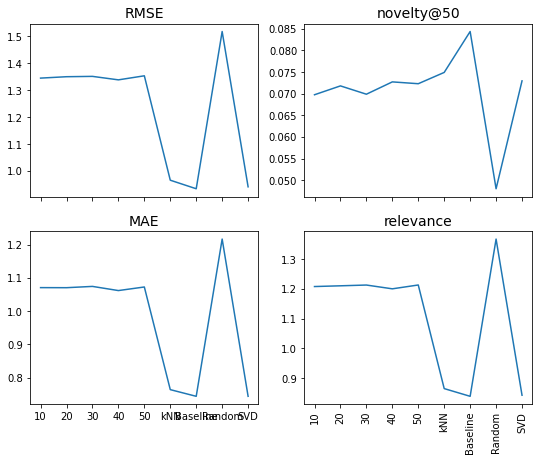

In [ ]:
metric_report["relevance"]

fig, ax = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=False)
X = np.array(["10", "20", "30", "40", "50", "kNN", "Baseline", "Random", "SVD"])
x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.xticks(x, X, rotation='vertical')

rmse = metric_report["rmse"].to_numpy()
ax[0, 0].plot(X, rmse)
ax[0, 0].set_title('RMSE', fontsize=14)

mae = metric_report["mae"].to_numpy()
ax[1, 0].plot(X, mae)
ax[1, 0].set_title('MAE', fontsize=14)

novelty = metric_report["novelty"].to_numpy()
ax[0, 1].plot(X, novelty)
ax[0, 1].set_title('novelty@50', fontsize=14)

relevance = metric_report["relevance"].to_numpy()
ax[1, 1].plot(X, relevance)
ax[1, 1].set_title('relevance', fontsize=14)

# plt.bar(X, rmse, color ='maroon',
#         width = 0.4)

# plt.bar(X, mae, color ='maroon',
#         width = 0.4)

In [ ]:
# graph
import matplotlib.pyplot as plt

# plt.figure(figsize=(20,10))

ilfm_metric = metric_report[:13]
other_metric = metric_report[13:]

# ilfm_metric["novelty"].plot.bar()
# plt.ylim(0.19, 0.21)

# ilfm_metric["rmse"].plot.bar()
# plt.ylim(1, 1.5)

# ilfm_metric["mae"].plot()
# plt.ylim(1, 1.5)

# metric_report["novelty"].plot.bar()
# plt.ylim(0.15, 0.25)

metric_report["rmse"].plot.bar()
plt.ylim(0.5, 2)

In [ ]:
# plt.figure(figsize=(20,10))
metric_report["novelty"].plot.bar()
plt.ylim(0.15, 0.25)

# Application

In [ ]:
# user to be tracked
tracked_user = '166'

data = Dataset.load_builtin('ml-100k')
tmp = pd.DataFrame(data.raw_ratings, columns=["userId", "movieId", "rating", "tstamp"])
rating_df = tmp.pivot(index='userId', columns='movieId', values='rating')

# show what movies the user has rated
# print(rating_df.columns)
# print(rating_df[tracked_user])

for rating in data.raw_ratings:
  if rating[0] == tracked_user:
    print(rating)

latent_features = 13
total_split = my_split(data, 2)
for split in total_split:
    trainset, testset_rated, testset_withunrated = split

    ilfm_model = ILFM(True, latent_features)
    funk_model = FunkSVD(latent_features)

    # train datasets
    ilfm_model.fit(trainset)
    funk_model.fit(trainset)

    # predict ratings
    # ilfm_predictions = ilfm_model.test(testset_rated)
    # funk_predictions = funk_model.test(testset_rated)
    ilfm_predictions = ilfm_model.getModel().T
    funk_predictions = funk_model.getModel().T
    # print("ilfm", ilfm_predictions)
    # print("funk", funk_predictions)

    # show predictions for tracked user
    # row_data = df.loc[ 'a' , : ]
    # ilfm_user_ratings = ilfm_predictions.loc["166", :]
    # funk_user_ratings = funk_predictions.loc["166", :]
    # print("ilfm", ilfm_user_ratings)
    # print("funk", funk_user_ratings)
    print("ilfm", ilfm_predictions.nlargest(5, '166').loc[:, '166'])
    print("funk", funk_predictions.nlargest(5, '166').loc[:, '166'])

    # find top 5
    

    # for prediction_list in ilfm_predictions:
    #   predictions_for_user = [(p.iid, p.est) for p in prediction_list if p.uid == tracked_user]
    #   predictions_for_user.sort(key = lambda x: x[1], reverse=True)
    #   top_5 = predictions_for_user[:5]
    #   print(top_5)
    # predictions_for_user = [(p.iid, p.est) for p in funk_predictions[0] if p.uid == tracked_user]
    # predictions_for_user.sort(key = lambda x: x[1], reverse=True)
    # top_5 = predictions_for_user[:5]
    # print(top_5)